# Data Processing

Take raw lap data and turn into something usable.
1. Import telemetry .csv
1. Import image data
1. Convert image data
1. Save image, telemetry, and target datasets

In [1]:
## Imports
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tensorflow.keras.preprocessing.image import img_to_array, load_img

2022-01-21 17:36:28.511742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Directories
data_directory = f'../data'
training_data_directory = f'{data_directory}/training_data'
datasets_directory = f'{data_directory}/{time.strftime("%m_%d_%Y/%H_%M_%S")}'

# File paths
image_dataset_file = f'{datasets_directory}/X_img.npy'
telem_dataset_file = f'{datasets_directory}/X_telem.pkl'
target_dataset_file = f'{datasets_directory}/y.npy'
processed_laps_file = f'{datasets_directory}/processed_laps.pkl'

# Telemetry
imu_data = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z',] # 'vel_x', 'vel_y', 'vel_z',]
telemetry_data = ['speed', 'pitch', 'yaw', 'roll', 'activeNode', 'first_lap']
# telemetry_columns = ['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'pitch', 'yaw', 'roll', 'activeNode', 'first_lap']
telemetry_data = ['speed', 'pitch', 'yaw', 'roll', 'activeNode']
telemetry_columns = telemetry_data

# Dummify if treating activeNode as categorical
dummify_nodes = False

# Rough cut times for valid laps 
lap_min_cutoff = 18
lap_max_cutoff = 18.75

In [3]:
## Make sure directoires exist
os.makedirs(data_directory, exist_ok=True)
os.makedirs(datasets_directory, exist_ok=True)

## Records

Steps:
* cut slow or incomplete laps
* process and save telemetry data
* import images as numpy arrays
* create numpy array of image data arrays
* save images as input dataset X
* save steering angle and throttle data in numpy array as target dataset y


In [4]:
## temporary list for dataframes
data_dfs = []

## get date directory names
date_dirs = [x for x in os.listdir(training_data_directory) if x != '.ipynb_checkpoints']

for dd in date_dirs:
    time_dirs = [y for y in os.listdir(f'{training_data_directory}/{dd}') if y != '.ipynb_checkpoints']
    for td in time_dirs:
        folder_path = f'{training_data_directory}/{dd}/{td}'
        temp_df = pd.read_csv(f'{folder_path}/data.csv')
        temp_df['folder'] = f'{dd}/{td}'
        data_dfs.append(temp_df.copy())
df = pd.concat(data_dfs)
df.head()

,steering_angle,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,gyro_x,...,activeNode,totalNodes,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,lap,folder
0.0,-0.435599,1.0,0.09238,7926.939.PNG,none,7926.939,-0.502833,0.059702,9.195234,0.000239,...,249,250.0,49.30835,5.220737,51.16883,-0.004586,0.000585,0.092264,0,01_19_2022/18_18_02
1.0,-0.435599,1.0,0.597563,7926.989.PNG,none,7926.989,-0.698276,-0.113828,10.059690,0.000332,...,249,250.0,49.30938,5.220132,51.14993,-0.037866,0.003318,0.596353,0,01_19_2022/18_18_02
2.0,-1.000000,1.0,1.101884,7927.039.PNG,none,7927.039,-0.648684,-0.175575,10.039660,0.000206,...,249,250.0,49.31209,5.218931,51.10566,-0.071202,-0.004083,1.099573,0,01_19_2022/18_18_02
3.0,-1.000000,1.0,1.585363,7927.089.PNG,none,7927.089,-1.944789,-0.168855,9.632171,0.000086,...,249,250.0,49.32021,5.217034,51.03714,-0.219057,-0.013636,1.570096,0,01_19_2022/18_18_02
4.0,-0.562432,1.0,2.073692,7927.139.PNG,none,7927.139,-1.428822,-0.135794,9.622944,0.000030,...,249,250.0,49.33434,5.214426,50.94466,-0.298161,-0.021059,2.052037,0,01_19_2022/18_18_02


### EDA/Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 417778 entries, 0.0 to 1760.0
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   steering_angle  417778 non-null  float64
 1   throttle        417778 non-null  float64
 2   speed           417778 non-null  object 
 3   image           417778 non-null  object 
 4   hit             417778 non-null  object 
 5   time            417778 non-null  float64
 6   accel_x         417778 non-null  float64
 7   accel_y         417778 non-null  float64
 8   accel_z         417778 non-null  float64
 9   gyro_x          417778 non-null  float64
 10  gyro_y          417778 non-null  float64
 11  gyro_z          417778 non-null  float64
 12  gyro_w          417778 non-null  float64
 13  pitch           417778 non-null  float64
 14  yaw             417778 non-null  float64
 15  roll            417778 non-null  float64
 16  cte             417778 non-null  float64
 17  active

#### Rename steering column to match throttle column

In [7]:
df.columns = ['steering' if col=='steering_angle' else col for col in df.columns]
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'time', 'accel_x', 'accel_y',
       'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'pitch', 'yaw', 'roll',
       'activeNode', 'pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z',
       'lap', 'folder'],
      dtype='object')

#### Convert dtypes to save space (?)

In [8]:
# print(f"before: {sys.getsizeof(df)}")

# for col in df.columns:
#     if df[col].dtype == 'float':
#         df[col] = pd.to_numeric(df[col], downcast='float')

# int_cols = ['activeNode','lap']
# for ic in int_cols:
#     df.loc[:,ic] = pd.to_numeric(df[ic], downcast='unsigned')

# print(f"after: {sys.getsizeof(df)}") 

#### Combine folder and lap for convenience

In [9]:
## should make sorting easier later
df['folder_lap'] = df['folder'] + '_' + df['lap'].astype(str)
df['folder_lap']

0.0       01_19_2022/18_18_02_0
1.0       01_19_2022/18_18_02_0
2.0       01_19_2022/18_18_02_0
3.0       01_19_2022/18_18_02_0
4.0       01_19_2022/18_18_02_0
                  ...          
1756.0    01_14_2022/00_24_35_1
1757.0    01_14_2022/00_24_35_1
1758.0    01_14_2022/00_24_35_1
1759.0    01_14_2022/00_24_35_1
1760.0    01_14_2022/00_24_35_1
Name: folder_lap, Length: 417778, dtype: object

#### Create lap time df

In [10]:
laps = pd.DataFrame(df.groupby(by='folder_lap')['time'].describe()[['max', 'min']])
laps

,max,min
folder_lap,,
01_13_2022/11_53_10_0,19.639570,19.039570
01_13_2022/11_53_10_1,41.239570,19.689570
01_13_2022/11_53_10_10,223.039600,204.339600
01_13_2022/11_53_10_11,230.989600,223.089600
01_13_2022/11_53_10_2,60.639560,41.289570
...,...,...
01_19_2022/19_22_29_5,8.853865,-28.404860
01_19_2022/19_22_49_0,0.138407,-0.200555
01_19_2022/19_22_49_1,582.381500,-29.257730


#### Calculate lap times

In [11]:
laps['lap_time'] = laps['max'] - laps['min']
laps['lap_time'].describe()

count    1403.000000
mean       16.418154
std        27.292254
min         0.117393
25%         7.400000
50%        18.750000
75%        19.300000
max       611.639230
Name: lap_time, dtype: float64

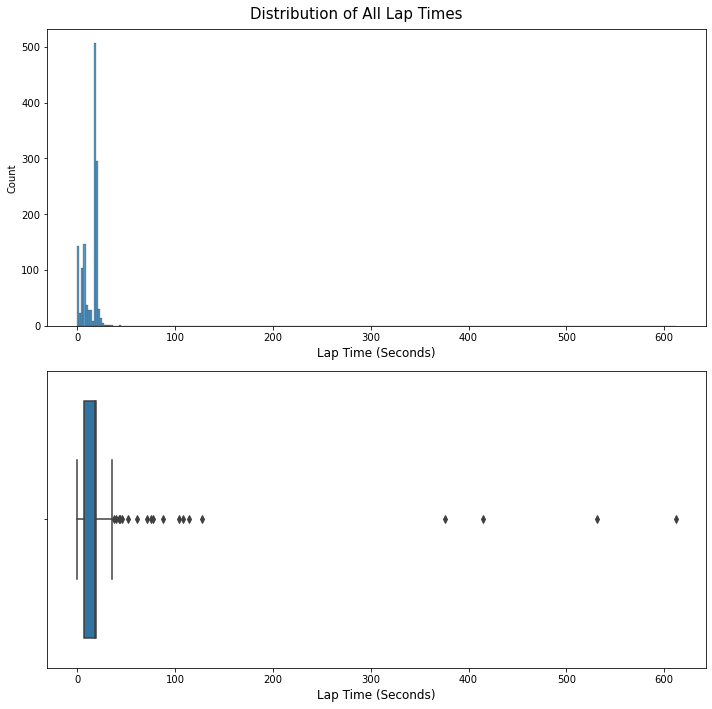

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of All Lap Times', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins='auto', ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Merge lap times into dataframe to make sorting easier

In [13]:
df = pd.merge(left=df, right=laps['lap_time'], left_on='folder_lap', right_index=True).copy()

#### Cut laps longer and shorter than specified length

In [14]:
df_pared = df.loc[(df['lap_time'] < lap_max_cutoff) & (df['lap_time'] > lap_min_cutoff), :].copy()
df_pared.shape

(58259, 25)

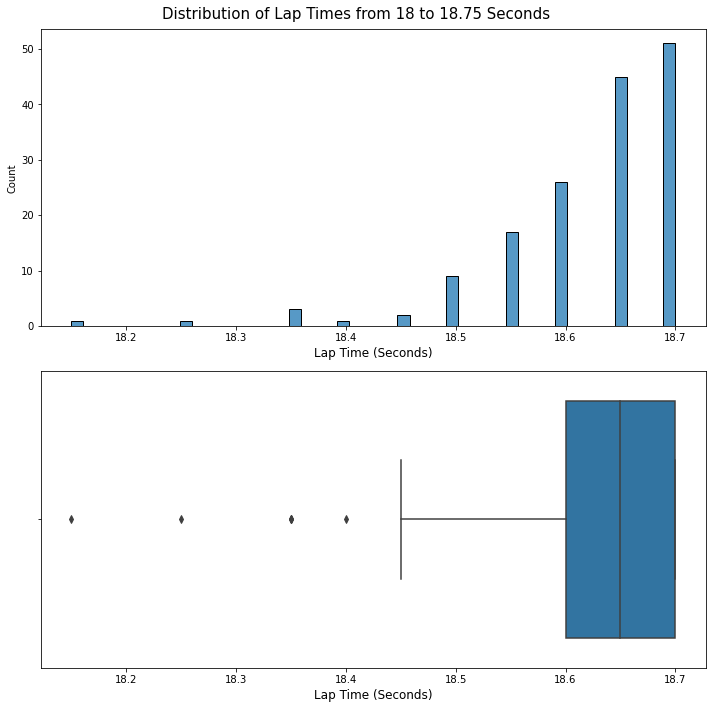

In [15]:
laps = laps.loc[(laps['lap_time'] < lap_max_cutoff) & (laps['lap_time'] > lap_min_cutoff), :].copy()

fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle(f'Distribution of Lap Times from {lap_min_cutoff} to {lap_max_cutoff} Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Remove incomplete laps that happen to have valid lap times

> Note: There are probably better ways to do this.

In [16]:
bad_laps = []
for fl in df_pared['folder_lap'].unique():
    if len(df_pared.loc[df_pared['folder_lap'] == fl, 'activeNode'].unique() ) < 249:
        bad_laps.append(fl)
print(f'Number of "bad" laps: {len(bad_laps)}')

Number of "bad" laps: 3


In [17]:
## Add any laps found "by hand" (via plotting) to list.
bad_laps.append(('01_14_2022/14_07_24', 149))

In [18]:
df_pared['lap_time'].describe()

count    58259.000000
mean        18.623146
std          0.089822
min         18.150000
25%         18.600000
50%         18.650000
75%         18.700000
max         18.700000
Name: lap_time, dtype: float64

In [19]:
df_pared = df_pared.loc[~df_pared['folder_lap'].isin(bad_laps), :].copy()
df_pared['lap_time'].describe()

count    57147.000000
mean        18.625836
std          0.085361
min         18.150000
25%         18.600000
50%         18.650000
75%         18.700000
max         18.700000
Name: lap_time, dtype: float64

#### Separate lap types

In [20]:
# redundant 
df_data = df_pared.sort_values(by=['folder_lap', 'time'], ascending=True).reset_index(drop=True)
df_data.head()

,steering,throttle,speed,image,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,...,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,lap,folder,folder_lap,lap_time
0,0.000000,1.0,28.60513,204.3396.png,204.3396,15.546010,-2.865708,2.997780,0.004151,0.001956,...,60.40037,5.121336,47.08025,-2.938994,0.201231,28.45303,10,01_13_2022/11_53_10,01_13_2022/11_53_10_10,18.7
1,0.000000,1.0,28.66435,204.3896.png,204.3896,34.340310,30.822530,8.217239,0.001395,-0.000053,...,60.28223,5.081322,45.66640,-2.372686,-0.627351,28.55909,10,01_13_2022/11_53_10,01_13_2022/11_53_10_10,18.7
2,0.000000,1.0,28.76649,204.4396.png,204.4396,9.937215,2.252591,1.631165,-0.000146,-0.000395,...,60.11203,5.086668,44.23843,-1.548044,-0.030455,28.72479,10,01_13_2022/11_53_10,01_13_2022/11_53_10_10,18.7
3,-0.099443,1.0,28.82705,204.4896.png,204.4896,6.054163,-0.746366,1.721573,0.000131,-0.000510,...,59.92381,5.093957,42.81059,-1.166551,-0.027311,28.80343,10,01_13_2022/11_53_10,01_13_2022/11_53_10_10,18.7
4,-0.099443,1.0,28.91201,204.5396.png,204.5396,8.659744,-0.076286,2.152634,0.000041,-0.001194,...,59.72652,5.099827,41.38054,-0.780402,-0.070358,28.90139,10,01_13_2022/11_53_10,01_13_2022/11_53_10_10,18.7


In [21]:
len(df_data['folder_lap'].unique())

153

#### Save lap data for plotting

In [22]:
df_data.to_pickle(processed_laps_file)

### Examine IMU data

In [23]:
X_imu = df_data[imu_data]
X_imu.describe()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,57147.000000,57147.000000,57147.000000,57147.000000,57147.000000,57147.000000
mean,-0.049221,0.010135,0.013635,0.000038,0.001663,0.000273
std,8.740389,6.746738,4.048929,0.001522,0.004078,0.001229
min,-280.586100,-126.104500,-197.820700,-0.020211,-0.023947,-0.025504
25%,-4.185868,-2.332955,-0.961971,-0.000646,0.000318,-0.000416
50%,-0.101888,0.014664,0.584793,0.000027,0.002308,0.000151
75%,3.998661,2.366951,1.957893,0.000665,0.004064,0.000931
max,191.585400,373.776800,44.533160,0.028138,0.036285,0.015268


### Look for IMU Outliers
> Note: This is mucking about by hand with arbitrarily chosen values. You might be able to skip this.

In [24]:
X_imu.loc[X_imu['accel_z'] > 200]

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z


In [25]:
X_imu.loc[X_imu['accel_x'] < -200]

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
24456,-236.0633,-57.75551,-161.9194,-0.009430,-0.008837,-0.011991
44400,-253.8225,-76.95872,-197.8207,0.028138,-0.023947,-0.014796
53811,-280.5861,-67.28090,-194.9974,-0.013111,-0.012558,-0.020680


In [26]:
X_imu.loc[X_imu['gyro_x'] < -0.04]

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z


In [27]:
X_imu.loc[X_imu['gyro_y'] > 0.4]

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z


In [28]:
X_imu.loc[X_imu['gyro_z'] < -0.03]

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z


In [29]:
# DON'T DO THIS BASED ON MY NUMBERS.
# imu_oulier_indices = [22236, 22808, 51003]

In [30]:
# X_imu = X_imu.drop(imu_oulier_indices).copy()

#### Plot

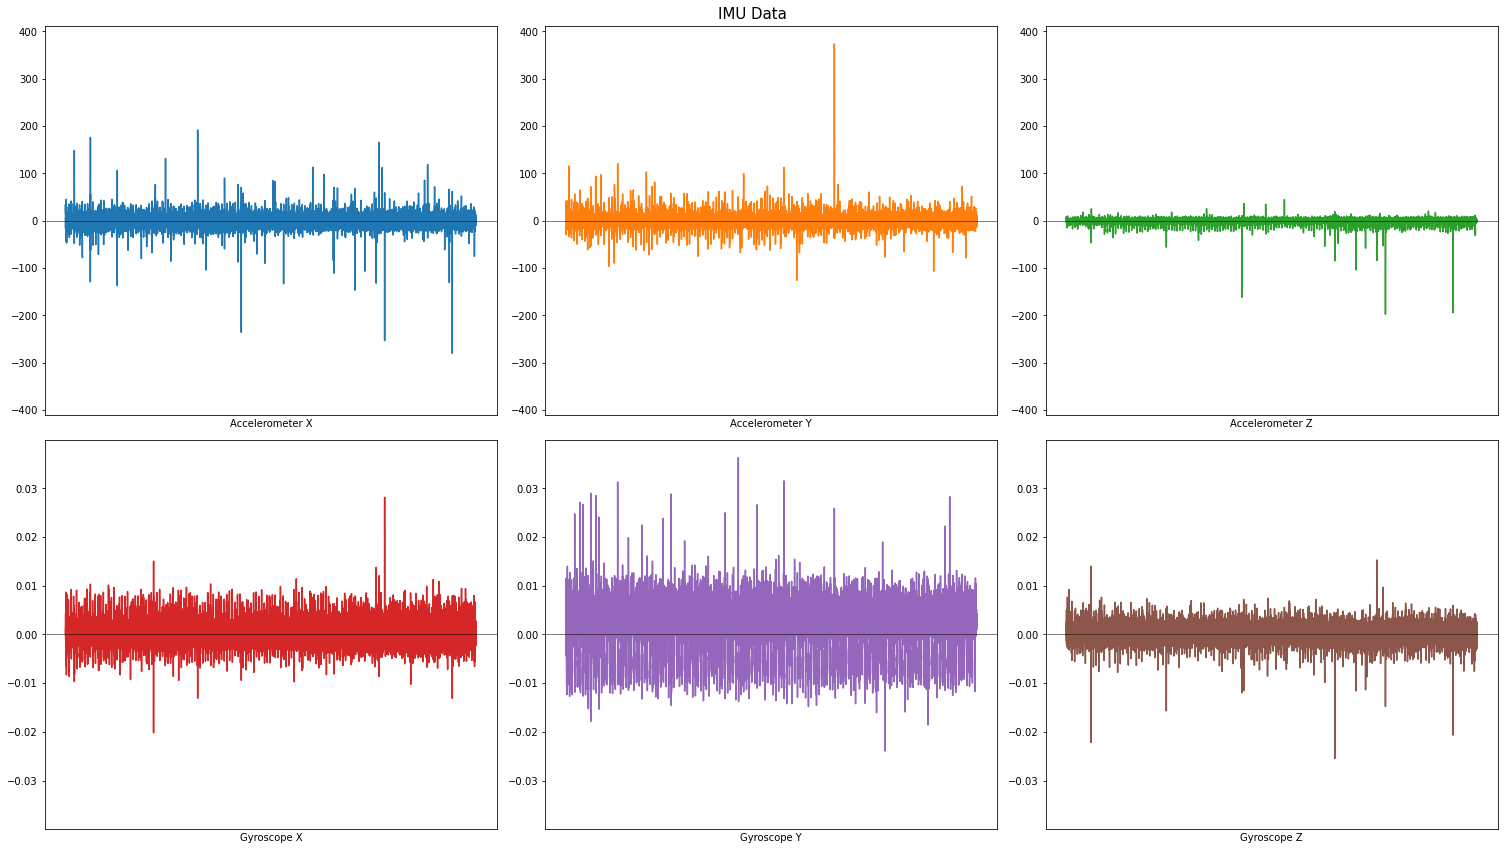

In [31]:
colors = [f'C{i}' for i in range(len(X_imu.columns))]

fig, ax = plt.subplots(2, 3, figsize=(21, 12))

fig.suptitle('IMU Data', size=15)

accel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['accel_x', 'accel_y', 'accel_z']) * 1.1
X_imu['accel_x'].plot(ax=ax[0][0], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer X', color=colors[0])
X_imu['accel_y'].plot(ax=ax[0][1], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Y', color=colors[1])
X_imu['accel_z'].plot(ax=ax[0][2], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Z', color=colors[2])

gyro_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['gyro_x', 'gyro_y', 'gyro_z']) * 1.1
X_imu['gyro_x'].plot(ax=ax[1][0], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope X', color=colors[3])
X_imu['gyro_y'].plot(ax=ax[1][1], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Y', color=colors[4])
X_imu['gyro_z'].plot(ax=ax[1][2], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Z', color=colors[5])

# vel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['vel_x', 'vel_y', 'vel_z']) * 1.1
# X_imu['vel_x'].plot(ax=ax[2][0], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity X', color=colors[6])
# X_imu['vel_y'].plot(ax=ax[2][1], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Y', color=colors[7])
# X_imu['vel_z'].plot(ax=ax[2][2], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Z', color=colors[8])

for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i][j].axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout();

*Comment*:
* The sheer number of laps makes it difficult to analyize when plotted together like thist

### Examime Telemetry Data

In [32]:
## Uncomment to drop the IMU ourliers if you care to do so
# df_data = df_data.drop(imu_oulier_indices).copy()

In [33]:
X_telem = df_data[telemetry_columns]
X_telem.describe()

,pitch,yaw,roll
count,57147.000000,57147.000000,57147.000000
mean,167.725877,178.680018,224.871027
std,177.403738,108.455148,166.508850
min,-0.005642,-0.002190,-0.005639
25%,1.754333,83.324915,5.404588
50%,6.680567,192.036100,345.942000
75%,358.392100,267.487800,353.345900
max,359.994200,359.991800,359.993800


#### Plot

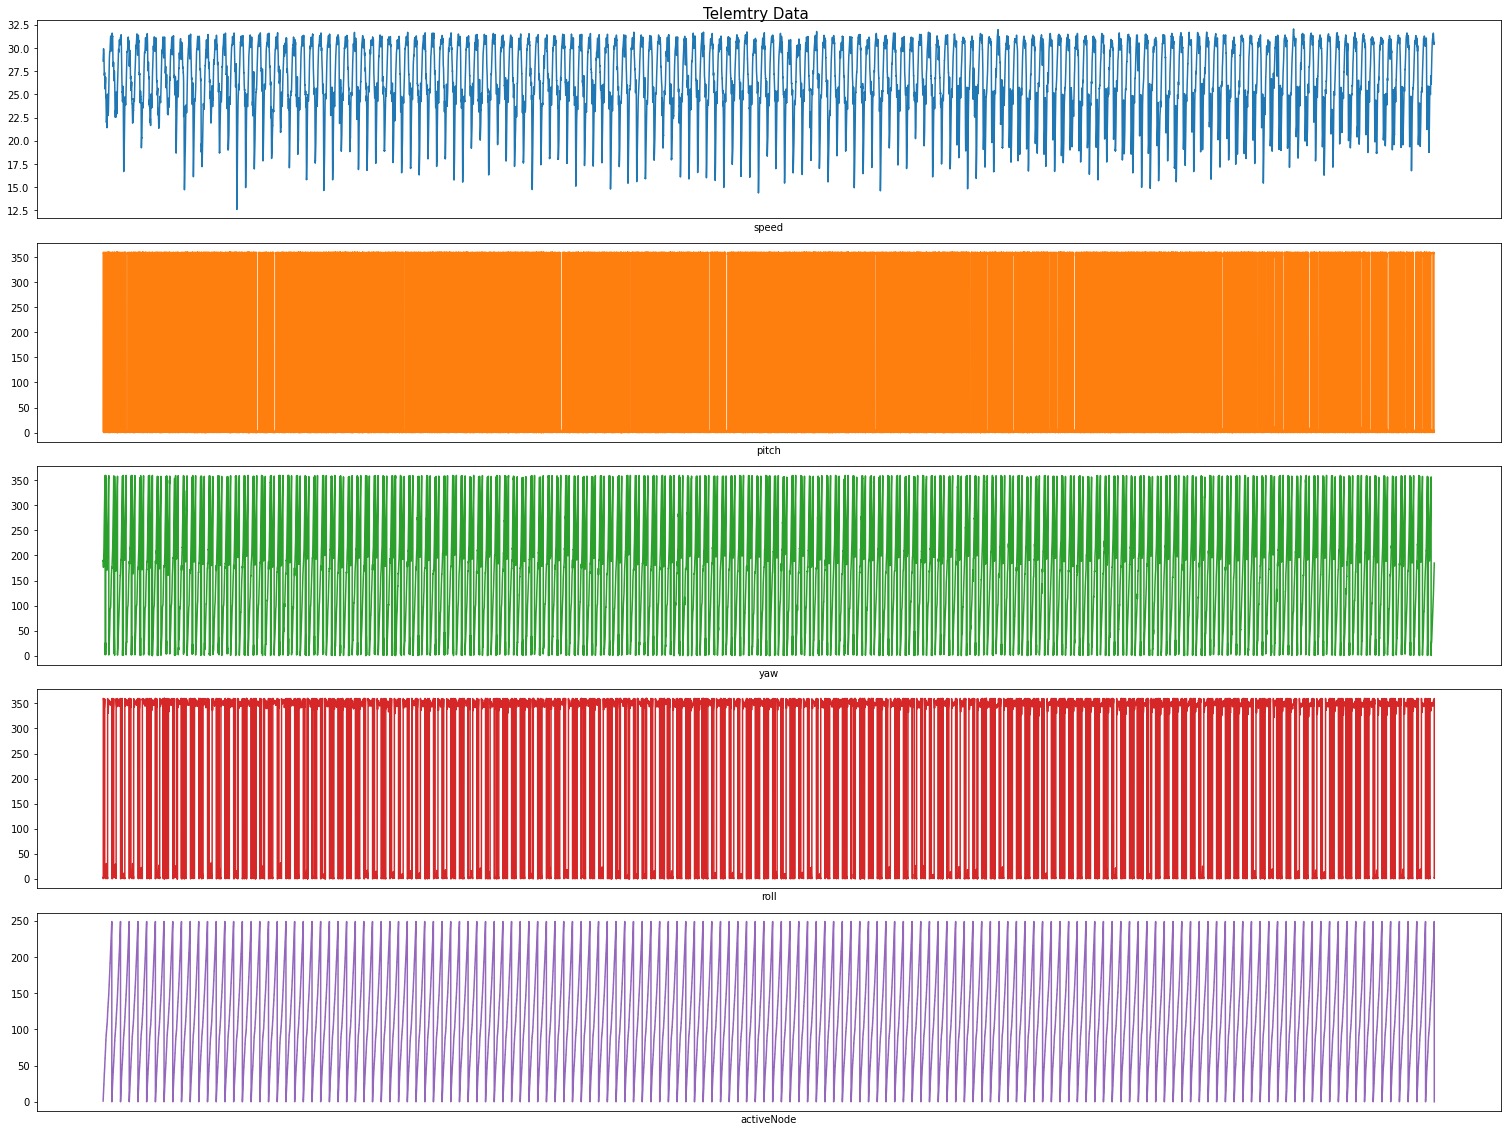

In [34]:
colors = [f'C{i}' for i in range(len(X_telem.columns))]
fig, ax = plt.subplots(len(telemetry_columns), 1, figsize=(21, len(telemetry_columns)*3 +1))
fig.suptitle('Telemtry Data', size=15)
for i in range(len(ax)):
    ax[i] = X_telem[telemetry_columns[i]].plot(ax=ax[i], xticks=[], xlabel=telemetry_columns[i], color=colors[i])
plt.tight_layout();

*Comment*:
* see above. a mess.

### Dummify Nodes

In [35]:
if dummify_nodes and 'activeNode' in telemetry_columns:
    X_telem = pd.get_dummies(data=X_telem, columns=['activeNode'])
X_telem.columns

Index(['speed', 'pitch', 'yaw', 'roll', 'activeNode'], dtype='object')

### Save Telemetry Data

In [36]:
X_telem

,speed,pitch,yaw,roll,activeNode
0,28.60513,2.111049,189.5059,2.296402,1
1,28.66435,359.256700,190.4281,1.875940,2
2,28.76649,359.565800,190.1534,1.353351,3
3,28.82705,359.639100,189.9259,0.949673,3
4,28.91201,359.621600,189.3905,0.624154,4
...,...,...,...,...,...
57142,30.53924,4.075859,178.0701,358.837200,247
57143,30.55777,3.914576,179.7270,359.193400,248
57144,30.57791,3.837833,181.3003,359.800500,249
57145,30.57642,3.037920,183.5619,0.718153,0


#### On second thought, let's take a look at pitch and roll.

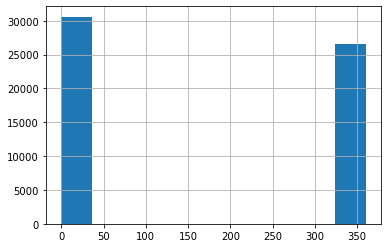

In [37]:
X_telem['pitch'].hist();

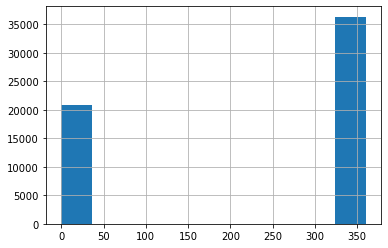

In [38]:
X_telem['roll'].hist();

> They don't look particularly helpful, so I'm dropping them

In [39]:
X_telem = X_telem.drop(columns=['pitch', 'roll']).copy()

In [40]:
## Save as pickle
X_telem.to_pickle(telem_dataset_file)

## Images

### Create Image Array
> This is a hilariously slow way to do this. I can do this on my machine with larger datasets because I have 32GB of RAM. I don't know what the limits will be on machines with less.

In [41]:
## Using keras, load images as list, adding to a list
img_array_list = []
for row in df_data.itertuples():
    path = f'{training_data_directory}/{row.folder}/images/{row.image}'
    img_array_list.append(img_to_array(load_img(path, color_mode='grayscale',))) 

In [42]:
## convert list of arrays into a numpy array (of arrays())
X_img = np.array(img_array_list)

### Scale Image Data
Image data are ints in \[0, 255\]. Models expect image data as floats \[0.0, 1.0\].

In [43]:
X_img /= 255

## Datasets

### Create Targets

In [44]:
## Target: throttle and steering data
y = df_data.loc[:, ['steering', 'throttle']].to_numpy().copy()

## Verify size
print(f'X.shape: {X_img.shape}')
print(f'y.shape: {y.shape}')

X.shape: (57147, 120, 160, 1)
y.shape: (57147, 2)


### Save Datasets

In [45]:
## Save as binary NumPy .npy format
with open(image_dataset_file, 'wb') as X_out:
    np.save(file=X_out, arr=X_img)
with open(target_dataset_file, 'wb') as y_out:
    np.save(file=y_out, arr=y)